# Introduction

In [1]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)

Windows-10-10.0.19045-SP0
Python 3.10.5 (tags/v3.10.5:f377153, Jun  6 2022, 16:14:13) [MSC v.1929 64 bit (AMD64)]


## Load and info

In [2]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme(style='darkgrid', palette='Set1')

from sklearn.datasets import fetch_california_housing

In [3]:
class cfg:
    seed = 42

In [4]:
# read data
# The dataset for this competition (both train and test) was generated from a 
# deep learning model trained on the California Housing Dataset. 
# Feature distributions are close to, but not exactly the same, as the original.

data_path = '../data/raw/'
train = pd.read_csv(data_path + 'train.csv', index_col=0).reset_index(drop=True)
test = pd.read_csv(data_path + 'test.csv', index_col=0).reset_index(drop=True)

train.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980
1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946
2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576
3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336
4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500


In [5]:
# quick info
TARGET = 'MedHouseVal'
FEATURES = [c for c in train.columns if c not in [TARGET]]

print(f'Target: {TARGET}\nFeatures: {FEATURES}')
print('Train set shape:', train.shape)
print('Test set shape:', test.shape)

Target: MedHouseVal
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Train set shape: (37137, 9)
Test set shape: (24759, 8)


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37137 entries, 0 to 37136
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       37137 non-null  float64
 1   HouseAge     37137 non-null  float64
 2   AveRooms     37137 non-null  float64
 3   AveBedrms    37137 non-null  float64
 4   Population   37137 non-null  float64
 5   AveOccup     37137 non-null  float64
 6   Latitude     37137 non-null  float64
 7   Longitude    37137 non-null  float64
 8   MedHouseVal  37137 non-null  float64
dtypes: float64(9)
memory usage: 2.6 MB


In [7]:
# get original df
data_orig = fetch_california_housing()

train_orig = pd.DataFrame(data_orig['data'], columns=FEATURES)
train_orig[TARGET] = data_orig['target']

train_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


## Eda

In [8]:
train_comb = pd.concat([train, train_orig])
train_comb['IsSynthetic'] = [1.0] *len(train) + [0.0] *len(train_orig)

spatial = ['Longitude', 'Latitude']
num = [c for c in FEATURES if c not in spatial]

fig_path = '../figures/eda/'
os.makedirs(fig_path, exist_ok=True)

In [9]:
# plotting df
toplot = train_comb.sample(1000, random_state=cfg.seed)

toplot['IsSynthetic'] = toplot['IsSynthetic'].astype(object)
toplot['ybin'] = pd.qcut(toplot[TARGET], 6, retbins=False)

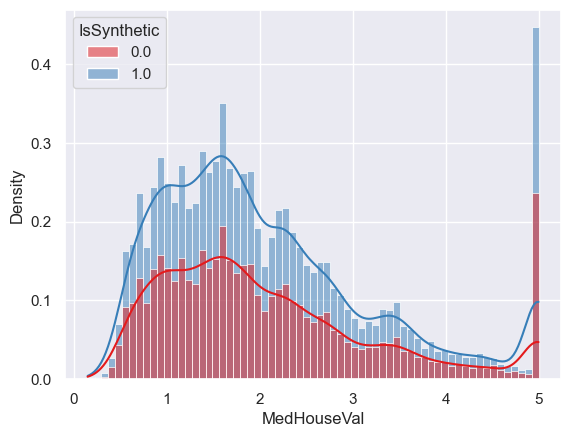

In [10]:
# target distribution
sns.histplot(train_comb, x=TARGET, hue='IsSynthetic', stat='density', kde=True)
plt.savefig(fig_path + 'target_density.jpg')

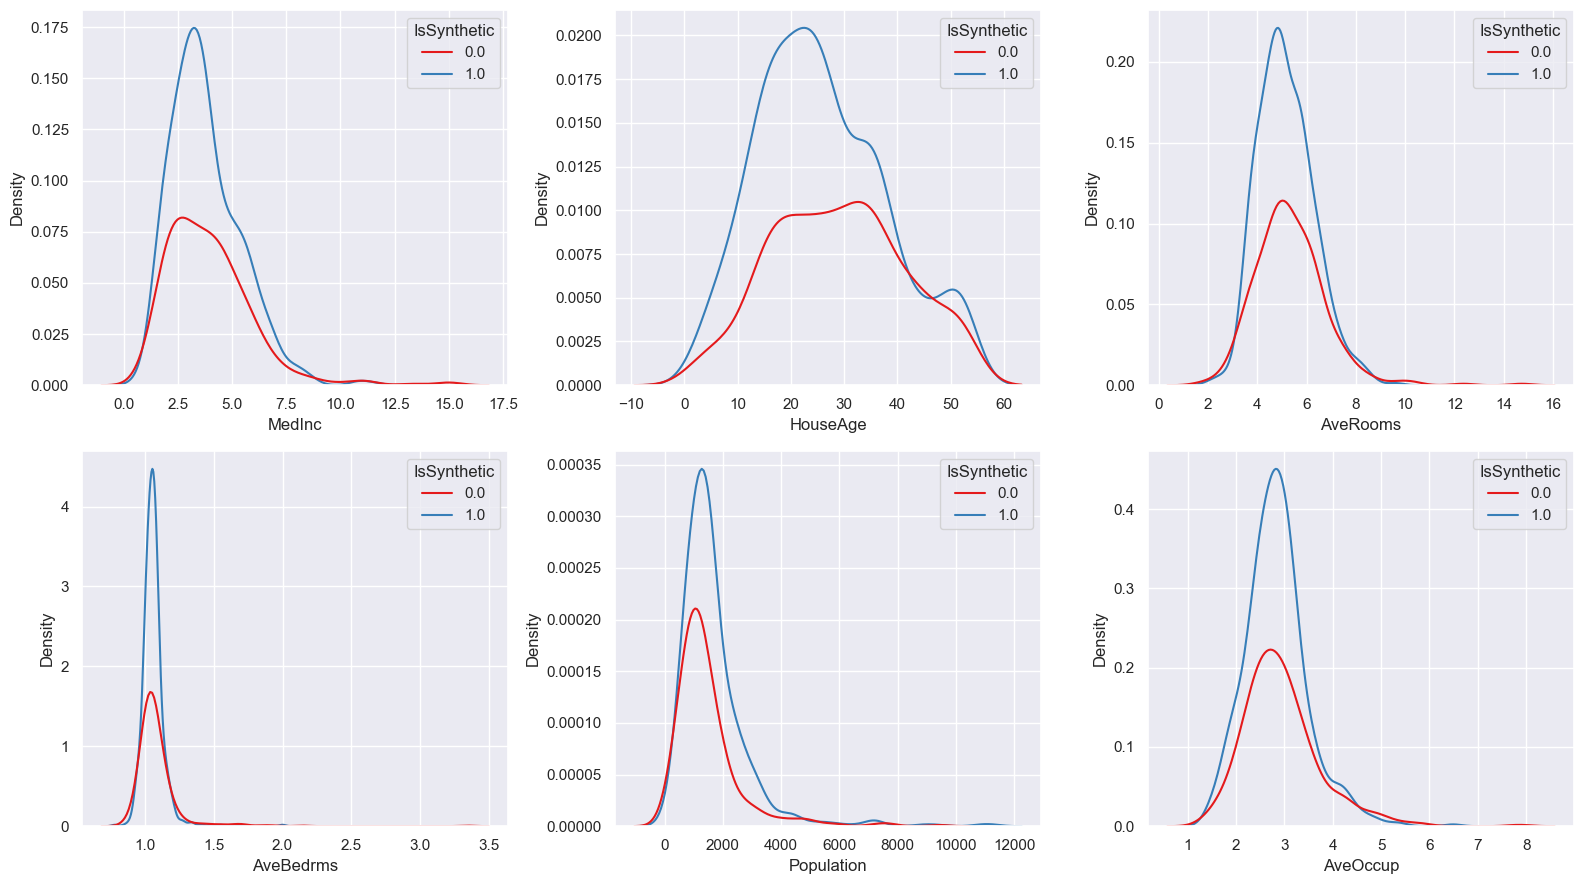

In [11]:
# univariate distributions
fig, axs = plt.subplots(2, 3, figsize = (16, 9))

for ax, c in zip(axs.flat, num):
    sns.kdeplot(toplot, x=c, hue='IsSynthetic', ax=ax)

plt.tight_layout()
plt.savefig(fig_path + 'numeric_density.jpg')

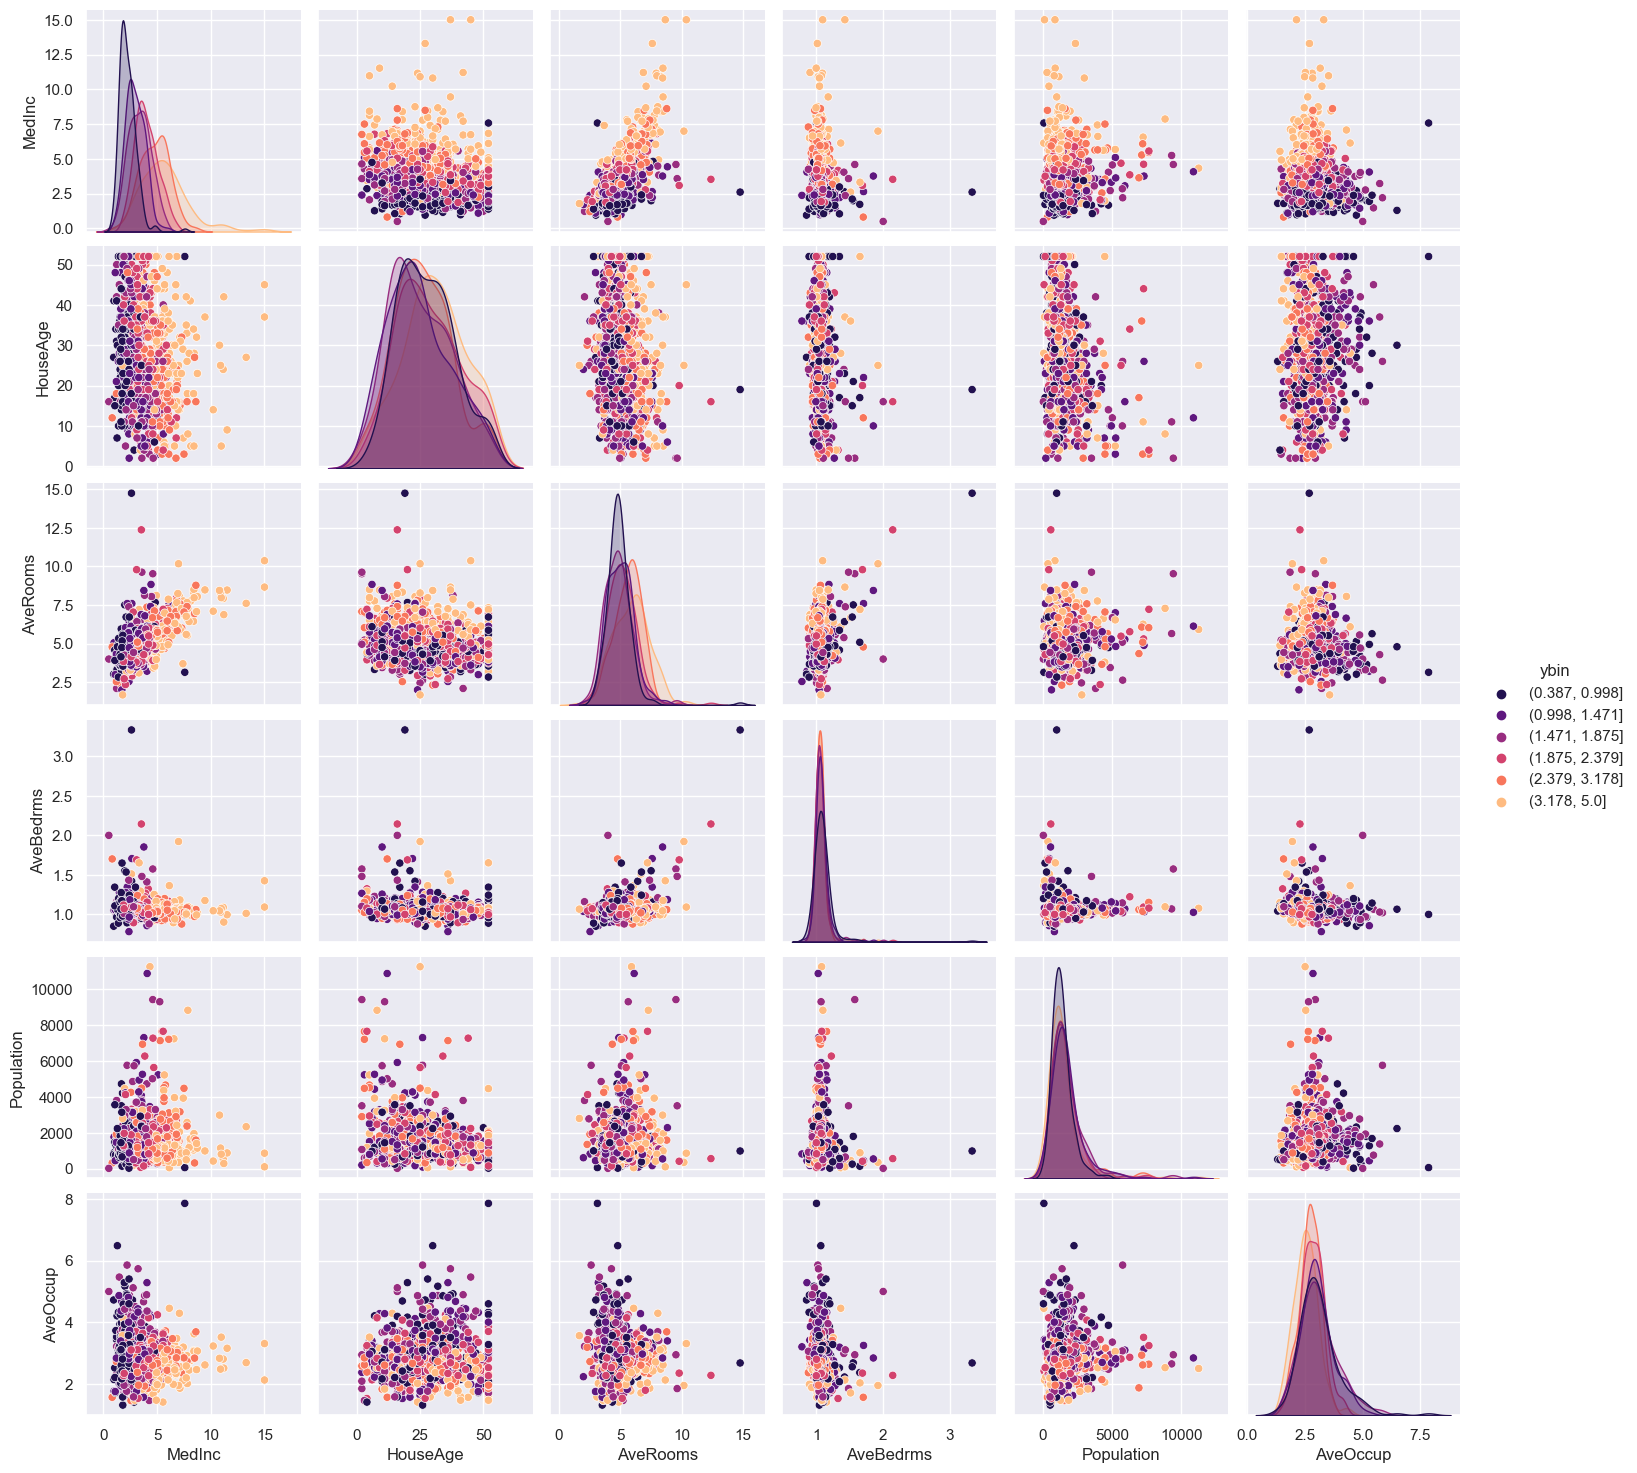

In [12]:
# pairplot
sns.pairplot(data = toplot.drop(columns=spatial+['IsSynthetic', TARGET]), hue='ybin', palette='magma')
plt.savefig(fig_path + 'numeric_pairplot.jpg')

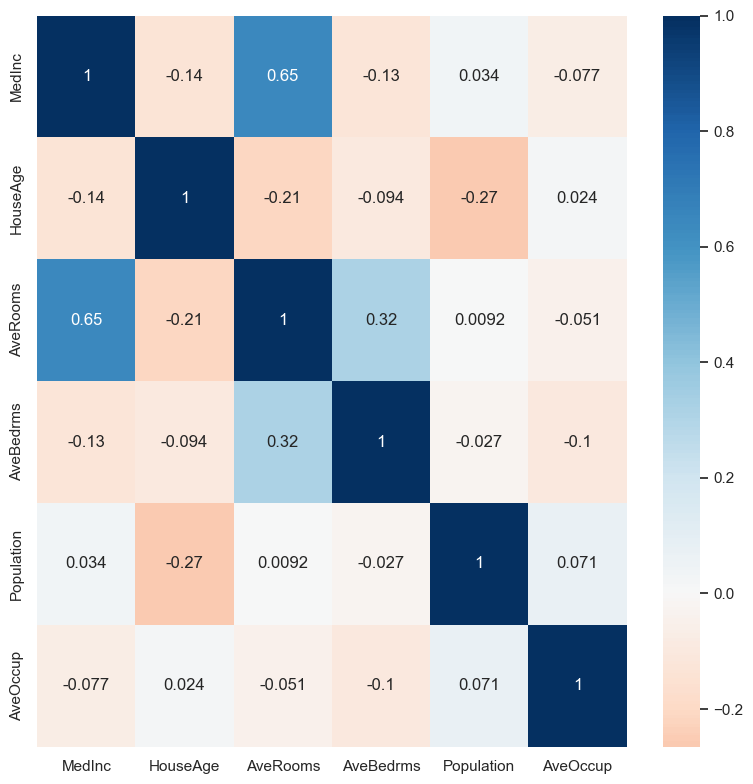

In [13]:
# corrplot
fig = plt.figure(figsize=(8, 8))
sns.heatmap(toplot[num].corr(), annot=True, cmap='RdBu', center=0)
plt.tight_layout()
plt.savefig(fig_path + 'numeric_corrplot.jpg')

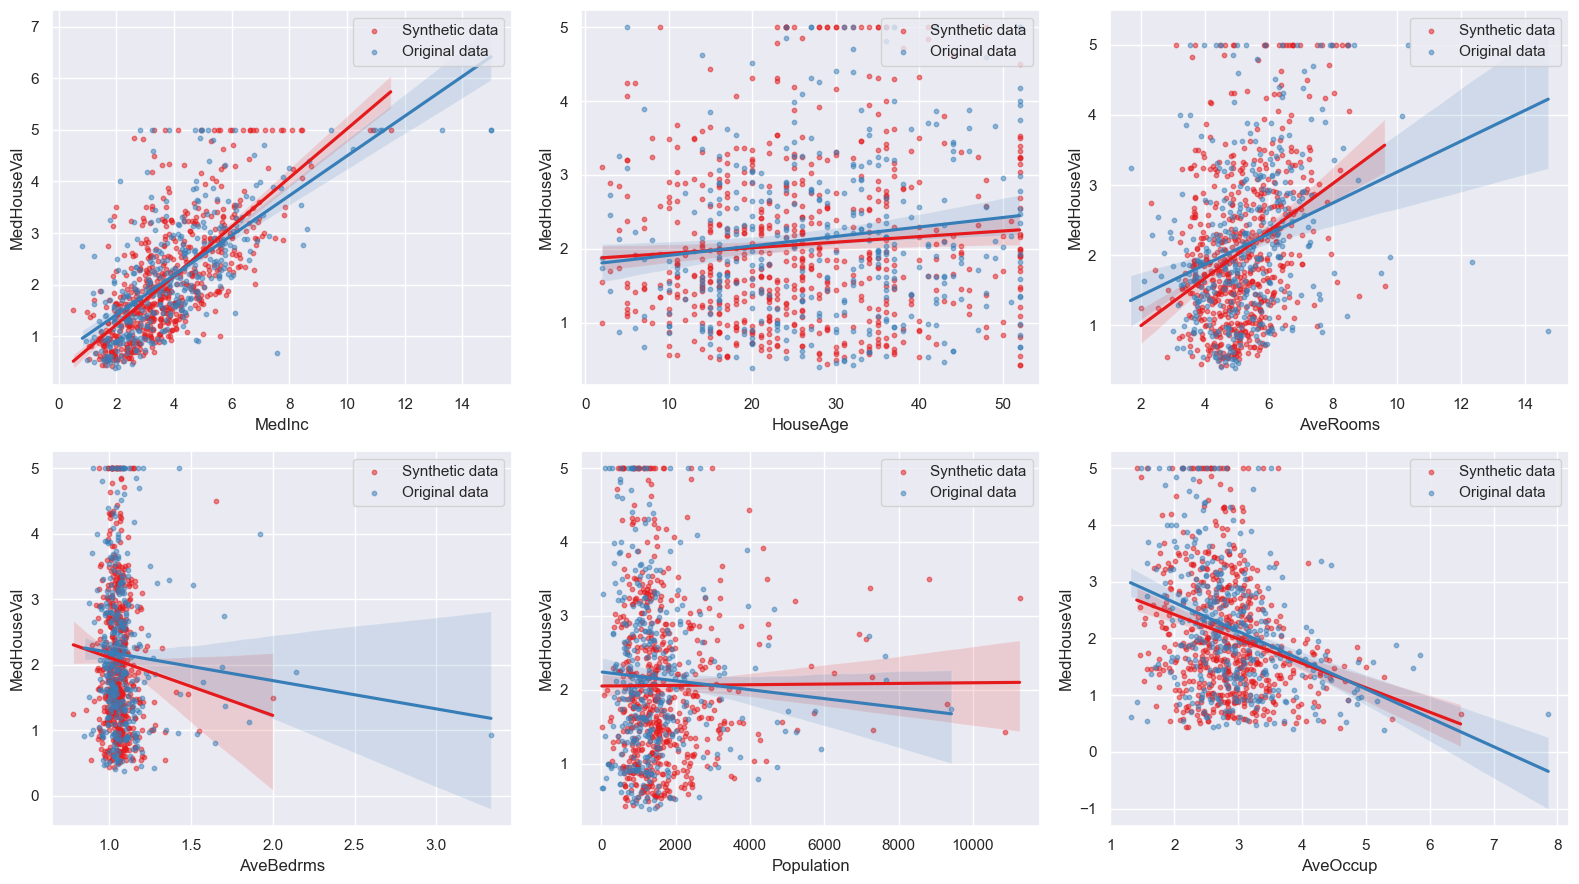

In [14]:
# bivariate plots
fig, axs = plt.subplots(2, 3, figsize = (16, 9))

palette = sns.color_palette('Set1')
for ax, c in zip(axs.flat, num):
    sns.regplot(data = toplot.loc[toplot['IsSynthetic']==1], ax=ax, x=c, y=TARGET, color=palette[0], scatter_kws={'alpha':0.5, 's':10}, label='Synthetic data')
    sns.regplot(data = toplot.loc[toplot['IsSynthetic']==0], ax=ax, x=c, y=TARGET, color=palette[1], scatter_kws={'alpha':0.5, 's':10}, label='Original data')
    ax.legend(loc='upper right', fontsize=11)

plt.tight_layout()
plt.savefig(fig_path + 'bivariate_regplot.jpg')

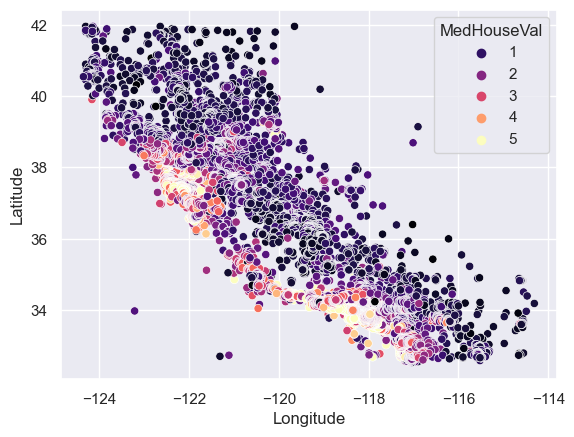

In [15]:
# long and lat
sns.scatterplot(data=train_comb, x='Longitude', y='Latitude', hue=TARGET, palette='magma')
plt.savefig(fig_path + 'spatial_scatterplot.jpg')

## Save data

In [16]:
out_path = '../data/extra/'
os.makedirs(out_path, exist_ok=True)

train_orig.to_csv(out_path + 'train_orig.csv', index=False)
train_comb.to_csv(out_path + 'train_comb.csv', index=False)